# The Multivariate Normal Distribution
Scott Linderman 



In [1]:
# !pip install torch==1.11

In [2]:
import torch
# print(torch.__version__) # Requires 1.11

from torch.distributions import Normal, MultivariateNormal, Wishart
torch.manual_seed(305)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

1.11.0+cu102


## The Generative Story

Start with a vector of standard normal random variates, $\mathbf{z} = [z_1, \ldots, z_D]^\top$ where $z_d {\sim} \mathcal{N}(0, 1)$.
    
This is a $D$-dimensional random variable, but not a very interesting one. All the coordinates are independent!
The joint density is,

$$
\begin{align*}
    p(\bf{z}) &= \prod_{d=1}^D \mathcal{N}(z_d \mid 0, 1) \\
    &= \prod_{d=1}^D \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} z_d^2} \\
    &= (2 \pi)^{-\frac{D}{2}} \exp\left\{ -\frac{1}{2} \sum_{d=1}^D z_d^2 \right\} \\
    &= (2 \pi)^{-\frac{D}{2}} \exp\left\{ -\frac{1}{2} \bf{z}^\top \bf{z} \right\}
\end{align*}
$$

What do the contours of this joint density look like in $D=2$ dimensions?

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


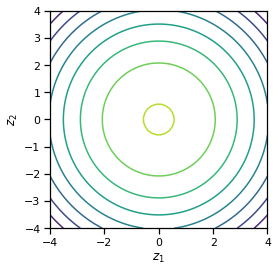

In [3]:
z1, z2 = torch.meshgrid(torch.linspace(-4, 4, 50),
                        torch.linspace(-4, 4, 50))

logpdf = Normal(0, 1).log_prob(z1) + Normal(0, 1).log_prob(z2)

plt.contour(z1, z2, logpdf)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.gca().set_aspect(1)

We can obtain more interesting joint distributions by transforming this random vector. 
    
For example, let $U$ be an orthogonal $D\times D$ matrix and $\Lambda = \mathrm{diag}([\lambda_1, \ldots, \lambda_D])$ with $\lambda_d > 0$.
Define the linearly transformed random variable $x = U \Lambda^{\frac{1}{2}} z$. 

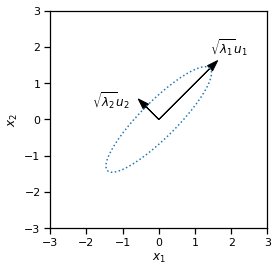

In [4]:
# Make an orthogonal 2 x 2 matrix
theta1 = torch.tensor(torch.pi / 4)
u1 = torch.tensor([torch.cos(theta1), torch.sin(theta1)])
theta2 = theta1 + torch.pi / 2
u2 = torch.tensor([torch.cos(theta2), torch.sin(theta2)])
U = torch.column_stack([u1, u2])

# choose two eigenvales
lmbda1 = torch.tensor(2.0**2)
lmbda2 = torch.tensor(0.5**2)
Lmbda = torch.tensor([lmbda1, lmbda2])

# pick one isocontour in z space and transform it to x coordinates
zs = torch.column_stack([
    torch.cos(torch.linspace(0, 2 * torch.pi, 50)),
    torch.sin(torch.linspace(0, 2 * torch.pi, 50))
])
xs = (zs * torch.sqrt(Lmbda)) @ U.T

# Plot the new basis
plt.plot(xs[:, 0], xs[:, 1], ':')
plt.arrow(0, 0, torch.sqrt(lmbda1) * u1[0], torch.sqrt(lmbda1) * u1[1], 
          color='k', head_width=0.2)
plt.text(torch.sqrt(lmbda1) * u1[0], torch.sqrt(lmbda1) * u1[1] + .4, 
         "$\sqrt{\lambda_1} u_1$")

plt.arrow(0, 0, torch.sqrt(lmbda2) * u2[0], torch.sqrt(lmbda2) * u2[1], 
          color='k', head_width=0.2)
plt.text(torch.sqrt(lmbda2) * u2[0] - 1.5, torch.sqrt(lmbda2) * u2[1], 
         "$\sqrt{\lambda_2} u_2$")

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect(1)

## Write a function to visualize covariance matrices

In [5]:
def plot_cov(Sigma, mu=None, ax=None, **kwargs):
    """
    Simple function to visualize a covariance matrix.
    """
    # Set the mean to zero if not given
    D = Sigma.shape[-1]
    mu = torch.zeros(D,) if mu is None else mu

    # Compute the eigendecomposition
    Lmbda, U = torch.linalg.eigh(Sigma)

    # Find one isocontour
    zs = torch.column_stack([
        torch.cos(torch.linspace(0, 2 * torch.pi, 50)),
        torch.sin(torch.linspace(0, 2 * torch.pi, 50))
    ])
    xs = (zs * torch.sqrt(Lmbda)) @ U.T

    # plot the isocontour
    ax = plt.axes(aspect=1) if ax is None else ax
    ax.plot(mu[0] + xs[:, 0], mu[1] + xs[:, 1], **kwargs)

## Draw many samples from a Wishart distribution and plot their inverses

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


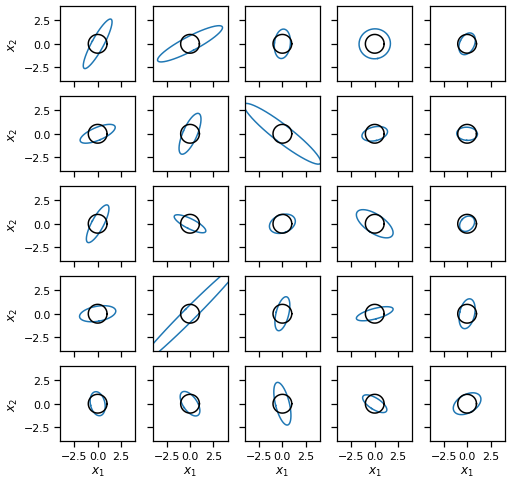

In [12]:
nu0 = torch.tensor(4.)
Lmbda0 = torch.eye(2) / nu0
Lmbdas = Wishart(nu0, covariance_matrix=Lmbda0).sample(sample_shape=(5, 5))

fig, axs = plt.subplots(5, 5, figsize=(8, 8), sharex=True, sharey=True)
for i in range(5):
    for j in range(5):
        plot_cov(torch.inverse(Lmbdas[i, j]), ax=axs[i, j])
        plot_cov(torch.eye(2), ax=axs[i, j], color='k')
        axs[i, j].set_xlim(-4, 4)
        axs[i, j].set_ylim(-4, 4)
        axs[i, j].set_aspect(1)

for i in range(5):
    axs[i, 0].set_ylabel("$x_2$")
    axs[-1, i].set_xlabel("$x_1$")

## Bayesian inference with unknown precision

The Wishart distribution is a conjugate prior for the precision of a multivariate normal distribution.

$$
\begin{align*}
    \Lambda &\sim \mathrm{W}(\nu_0, \Lambda_0), \\
    x_n &\sim \mathcal{N}(\mu, \Lambda^{-1}).
\end{align*}
$$

Then, letting $\eta = (\mu, \nu_0, \Lambda_0)$,

$$
\begin{align*}
    p(\Lambda \mid x, \eta) 
    &\propto \mathrm{W}(\Lambda \mid \nu_0, \Lambda_0) \prod_{n=1}^N \mathcal{N}(x_n \mid \mu, \Lambda^{-1}) \\
    &\propto |\Lambda|^{\frac{\nu_0 - D - 1}{2}} e^{-\frac{1}{2} \mathrm{Tr}(\Lambda_0^{-1} \Lambda)} \prod_{n=1}^N |\Lambda|^{\frac{1}{2}} e^{-\frac{1}{2} (x_n - \mu)^\top \Lambda (x_n - \mu)} \\
    &\propto |\Lambda|^{\frac{\nu_0 + N - D - 1}{2}} \exp\left\{-\frac{1}{2} \mathrm{Tr}\left(\left[\Lambda_0^{-1} + \sum_{n=1}^N (x_n -\mu) (x_n - \mu)^\top \right] \Lambda \right) \right\}
\end{align*}
$$

We recognize this as yet another Wishart distribution,
    
$$
\begin{align*}
    p(\Lambda \mid x, \eta) &\propto \mathrm{W}(\Lambda \mid \nu_N, \Lambda_N),
\end{align*}
$$

where 

$$
\begin{align*}
    \nu_N &= \nu_0 + N \\
    \Lambda_N &= \left[\Lambda_0^{-1} + \sum_{n=1}^N (x_n -\mu) (x_n - \mu)^\top \right]^{-1}
\end{align*}
$$

In [7]:
# Sample data from a Gaussian with identity covariance (and precision)
torch.manual_seed(305)
N = 10
x = MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((N,))

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


Text(0, 0.5, '$x_2$')

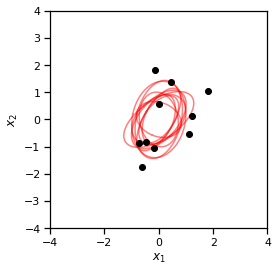

In [8]:
# Set a weak prior
nu_0 = torch.tensor(1.0)
Lmbda_0 = torch.eye(2)

# Compute the posterior distribution over the precision under a Wishart prior, 
# assuming the mean is known to be zero
nu_N = nu_0 + N 
Lmbda_N = torch.inverse(torch.inverse(Lmbda_0) + x.T @ x)
posterior = Wishart(nu_N, Lmbda_N)

# Plot posterior samples of the *covariance* (i.e. inverse precision)
precision_samples = posterior.sample((10,))
covariance_samples = torch.inverse(precision_samples)

ax = plt.axes(aspect=1)
for Sigma in covariance_samples:
    plot_cov(Sigma, ax=ax, color='r', alpha=0.5)
plt.plot(x[:, 0], x[:, 1], 'ko', markersize=6)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

## Bayesian Inference with Unknown Mean and Precision

What if both the mean and the precision are unknown? Then a normal-Wishart prior is conjugate with the multivariate normal likelihood.
We say 

$$
\begin{align*}
\boldsymbol{\mu}, \boldsymbol{\Lambda} &\sim \mathrm{NW}(\boldsymbol{\mu}_0, \kappa_0, \nu_0, \boldsymbol{\Lambda}_0)
\end{align*}
$$

if

$$
\begin{align*}
\boldsymbol{\Lambda} &\sim \mathrm{W}(\nu_0, \boldsymbol{\Lambda}_0) \\
\boldsymbol{\mu} \mid \boldsymbol{\Lambda} &\sim \mathcal{N}(\boldsymbol{\mu}_0, (\kappa_0 \boldsymbol{\Lambda})^{-1})
\end{align*}
$$

Under a multivariate Gaussian likelihood,

$$
\begin{align*}
p(\mathbf{X} \mid \boldsymbol{\mu}, \boldsymbol{\Lambda}, \boldsymbol{\eta}) &=
\prod_{n=1}^N \mathcal{N}(\mathbf{x}_n \mid \boldsymbol{\mu}, \boldsymbol{\Lambda}^{-1}).
\end{align*}
$$

Then, the posterior on the parameters is another normal-Wishart distribution with parameters

$$
\begin{align*}
\nu_N &= \nu_0 + N \\
\kappa_N &= \kappa_0 + N \\
\boldsymbol{\Lambda}_n &= \left[ \boldsymbol{\Lambda}_0^{-1} + \kappa_0 \boldsymbol{\mu}_0 \boldsymbol{\mu}_0^\top + \sum_{n=1}^N \mathbf{x}_n \mathbf{x}_n^\top - \kappa_N \boldsymbol{\mu}_N \boldsymbol{\mu}_N^\top \right]^{-1} \\
\boldsymbol{\mu}_N &= \frac{1}{\kappa_N} \left( \kappa_0 \boldsymbol{\mu}_0 + \sum_{n=1}^N \mathbf{x}_n \right)
\end{align*}
$$

Next, we'll compute the posterior of $\boldsymbol{\mu}$ and $\boldsymbol{\Lambda}$ and visualize it.


In [9]:
# Set a weak prior
nu_0 = torch.tensor(1.0)
Lmbda_0 = torch.eye(2)
kappa_0 = torch.tensor(1.0)
mu_0 = torch.zeros((2,))


# Compute the posterior distribution over the mean and precision under a 
# normal-Wishart prior with the hyperparameters above.
nu_N = nu_0 + N 
kappa_N = kappa_0 + N
mu_N = 1/kappa_N * (kappa_0 * mu_0 + x.sum(axis=0))
Lmbda_N = torch.inverse(torch.inverse(Lmbda_0) 
                        + kappa_0 * torch.outer(mu_0, mu_0) 
                        + x.T @ x
                        - kappa_N * torch.outer(mu_N, mu_N))

# Sample the posterior
posterior_Lambda = Wishart(nu_N, Lmbda_N)
Lambda_samples = posterior.sample((100,))
Sigma_samples = torch.inverse(Lambda_samples)

posterior_mu = MultivariateNormal(mu_N, 
                                  precision_matrix=Lambda_samples * kappa_N)
mu_samples = posterior_mu.sample()


/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


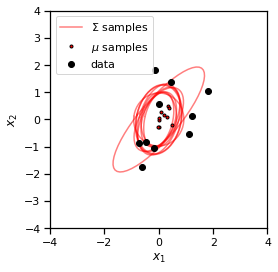

In [10]:
# Plot posterior samples of the Gaussian parameters
ax = plt.axes(aspect=1)
for i, (mu, Sigma) in enumerate(zip(mu_samples[:10], Sigma_samples[:10])):
    plot_cov(Sigma, ax=ax, color='r', alpha=0.5, 
             label='$\Sigma$ samples' if i == 0 else None)

    plt.plot(mu[0], mu[1], 'ro', markersize=3, mec='k', 
             label='$\mu$ samples' if i == 0 else None)

plt.plot(x[:, 0], x[:, 1], 'ko', markersize=6, label='data')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()

## Recap
This notebook introduced the `MultivariateNormal` and `Wishart` distributions. We gave examples of how you can visualize 2 dimensional covariance matrices (and inverse precision matrices) as ellipses in $\mathbb{R}^2$. This is a helpful way of visualizing prior distributions, like the Wishart distribution.

A couple of notes:
- PyTorch does not currently have an inverse Wishart distribution object. In theory, you could implement one as a `TransformedDistribution`, but you would need to also write a `MatrixInverseTransform` object. None of this is particularly hard, but it was more than we chose to do for this demo.
- In practice, many practitioners suggest using the `LKJCholesky` distribution as a prior on covariance matrices (technically, their square roots). It doesn't have as simple a closed form update as the Wishart or inverse Wishart, but it is amenable to other inference techniques that we'll discuss later in the course.